# Spark Pipeline on Kickstarter Pledge Dataset

## 1. Overview

### 1.1. Instructions

- **Choosing any sufficiently large open dataset** (less than 100000 lines are not allowed)


- **Choosing one variable to predict**


- **Implementing at least two supervised learning models**: classification, regression, recommender system, etc. Unsupervised tasks (e.g. clusterisation, associative rules, etc.) are not allowed


- **Mandatory use of Apache Spark** (e.g. on Google Cloud as we did during our lab sessions)


- A **full machine learning pipeline must be implemented**, which include:
    - Reading the data
    - Transforming data (extracting features, dealing with missing values if any, etc.)
    - Building models (build at least two models to compare)
    - Evaluating quality (use cross-validation or train/test split)

### 1.2. Dataset

We will be using the [Kickstarter Projects](https://www.kaggle.com/kemical/kickstarter-projects) Kaggle dataset. It contains two .csv files dated December 2016 and January 2018 which contains lists of kickstarter campaigns, explicited with the following data fields:

- ID
- name
- category
- main_category
- currency
- deadline
- goal
- launched
- pledged
- state
- backers
- country
- usd_pledged: conversion in US dollars of the pledged column 
- usd_pledged_real: conversion in US dollars of the pledged column
- usd_goal_real: conversion in US dollars of the goal column


### 1.3. Goal

Kickstarter is a crowdfunding platform where people, companies, etc. can set a campaign where people can pledge money in exchange for a future product (those people are called backers). Being able to predict the success of a campaign has important application in marketing, as such:

> Our goal will be to predict the **state** value of campaigns based on any number other columns (our features), excluding *usd_pledged* and *usd_pledged_real*.

The notebook was also ran locally using the installation steps for Spark described [here](https://sparkbyexamples.com/spark/spark-installation-on-linux-ubuntu/).

## 2. Environment Set-Up

We need the following libraries installed to set up the environment:

- kaggle (see documentation [here](https://github.com/Kaggle/kaggle-api#datasets))
- pyspark (see documentation [here](https://spark.apache.org/docs/latest/api/python/index.html))

In [1]:
# Installs the kaggle and pyspark module on the machine
!pip install kaggle
# !pip uninstall pyspark -y
!pip install pyspark
# !pip install bigdl==0.12.1 # requires Python 3.6 or 3.7

## 3. Dataset Download

In [2]:
# Removes previously existing files
!rm -f kickstarter-projects.zip
!rm -f ks-projects-201612.csv ks-projects-201801.csv

### 3.1. Setting up Kaggle environment variables with the kaggle.json file

#### 3.1.2. On Google Cloud

<span style="color:red">To download the kaggle dataset, we must first upload our account's **kaggle.json file** in the **/root/.kaggle/ folder**.</span>
    
<span style="color:red">The kaggle.json file can be downloaded here:</span>

> ``https://www.kaggle.com/<username>/account``
    
<span style="color:red">It is assumed we created a **/home/\<user\>/ folder** where this Jupyter Notebook and the kaggle.json file have been uploaded</span>.

#### 3.1.2. On a local machine
    
<span style="color:red">Download and move the kaggle.json file to the local /root/.kaggle/ folder.</span>

### 3.2. Downloading the dataset

We only keep 'ks-projects-201801.csv', the most recent dataset available.

In [3]:
# Dowloads the raw dataset from the kaggle source
!kaggle datasets download -d kemical/kickstarter-projects

100%|██████████████████████████████████████| 36.8M/36.8M [00:07<00:00, 6.07MB/s]
100%|██████████████████████████████████████| 36.8M/36.8M [00:07<00:00, 5.17MB/s]


In [4]:
# Unzips the raw dataset and keeps only the most recent instance
!unzip kickstarter-projects.zip
!rm -f ks-projects-201612.csv kickstarter-projects.zip

Archive:  kickstarter-projects.zip
  inflating: ks-projects-201612.csv  
  inflating: ks-projects-201801.csv  


### 3.3. Uploading to HDFS when using Google Cloud

## 4. Library Imports & Setting Spark/Global Environment Variables

In [5]:
# Loads the needed modules
from pyspark.context import SparkContext

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler 
from pyspark.ml.feature import Word2Vec, Tokenizer, HashingTF
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql import Row
from pyspark.sql.functions import unix_timestamp, ceil, isnan, when, count, col
from pyspark.sql.session import SparkSession
from pyspark.sql.types import DoubleType

In [6]:
############## WARNING ###########
# RUN ONLY WHEN ON A LOCAL MACHINE
##################################

dataset_path = "ks-projects-201801.csv"
dataset_format = "csv"
context = "local"

# Instantiates a local Spark Session
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .appName("distributed-database-assignment") \
    .getOrCreate()

## 5. Loading the Kickstarter Dataset

<span style="color:red">Comment out the following cell when when running the notebook Google Cloud as a spark session is automatically instantiated.</span>

In [7]:
#Spark UI on Google Cloud should return:
#   v2.3.4 (version)
#   yarn (Master)
#   PySparkShell (AppName)

spark

In [8]:
# Loads the dataset
campaigns = (spark
             .read
             .format(dataset_format)
             .options(header=True)
             .load(dataset_path))

## 6. Dataset Pre-Processing

In [9]:
# Declares variables for pre-processing the dataset
kept_raw_columns = [
    "ID","name","category","deadline","launched","country","usd_goal_real", #features
    "state" # target
]

remove_date_columns = [
    "ID","name","category","total_duration","country","usd_goal_real", #features
    "state" # target
]

kept_columns_for_modelization = [
    "total_duration","usd_goal_real","name","category","country", #features
    "state" # target
]

deadline_format = "yyyy-MM-dd"
launched_format = "yyyy-MM-dd HH:mm:ss"

final_columns = ["scaled_features", "label"]

In [10]:
# Declares useful functions
def dataset_check(db):
    print("The dataset contains " + str(db.count()) + " rows.")
    db.show(n=5)

In [11]:
# Checks the type of the dataset columns
campaigns.printSchema()

root
 |-- ID: string (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: string (nullable = true)
 |-- goal: string (nullable = true)
 |-- launched: string (nullable = true)
 |-- pledged: string (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: string (nullable = true)
 |-- country: string (nullable = true)
 |-- usd pledged: string (nullable = true)
 |-- usd_pledged_real: string (nullable = true)
 |-- usd_goal_real: string (nullable = true)



In [12]:
# Drops NAs, Nulls, and Duplicates 
campaigns = campaigns.dropna()
campaigns = campaigns.dropDuplicates()
for column in campaigns.columns:
    campaigns = campaigns.where(col(column).isNotNull())

In [13]:
# Prunes the non-relevant columns
campaigns = campaigns.select(kept_raw_columns)

In [14]:
# Computes a duration time (in day) between the launch and deadline features
launch_times = unix_timestamp("launched", format = launched_format)
deadline_times = unix_timestamp("deadline", format = deadline_format)
time_difference = deadline_times - launch_times
campaigns = campaigns.withColumn("total_duration",ceil(time_difference/(3600*24)))

# Removes the launch and deadline feature columns
campaigns = campaigns.select(remove_date_columns)

In [15]:
# Cleans the target labels:
#   - 'undefined', 'live' -> dropped
for condition in ['state!="undefined"', 'state!="live"']:
    campaigns = campaigns.where(condition)

#   - 'suspended', 'cancelled' -> renamed to 'failed' 
campaigns = campaigns.\
    withColumn("state",when(col("state") == "canceled", "failed").\
    when(col("state") == "suspended", "failed").\
    when(col("state") == "failed", "failed").\
    otherwise("successful"))

In [16]:
# Casts the relevant column(s) to their end types
for column in ["total_duration", "usd_goal_real"]:
    campaigns = campaigns.withColumn(column,col(column).cast(DoubleType()))

In [17]:
# finishes clean-up
processed_campaigns = campaigns.select(kept_columns_for_modelization)

With the preprocessed campaigns, we can both explore the data better and build our Spark pipelines.

### 6.1. Exploring the pre-processed campaigns

In [18]:
def count_unique_instances(df, column_name):
    """
    Prints the count of each unique instance in a column in descending order
    """
    df.select(column_name).groupBy(column_name).count().orderBy(col("count").desc()).show()

In [19]:
# Checks dataset structure
dataset_check(processed_campaigns)

The dataset contains 372060 rows.
+--------------+-------------+--------------------+--------------+-------+----------+
|total_duration|usd_goal_real|                name|      category|country|     state|
+--------------+-------------+--------------------+--------------+-------+----------+
|          43.0|      4926.39|             Borders|         Drama|     GB|    failed|
|          21.0|      2240.39|Spiele für iOS un...|  Mobile Games|     DE|    failed|
|          30.0|        700.0|Odyssey Skateboar...|Graphic Design|     US|    failed|
|          30.0|       5500.0|Debut EP Album Pr...|           R&B|     US|    failed|
|          16.0|       1200.0|GBS Detroit Prese...|    Indie Rock|     US|successful|
+--------------+-------------+--------------------+--------------+-------+----------+
only showing top 5 rows



In [20]:
processed_campaigns.dtypes

[('total_duration', 'double'),
 ('usd_goal_real', 'double'),
 ('name', 'string'),
 ('category', 'string'),
 ('country', 'string'),
 ('state', 'string')]

In [21]:
# Checks for N/A
processed_campaigns.select([count(when(isnan(c), c)).alias(c) for c in processed_campaigns.columns]).show()

+--------------+-------------+----+--------+-------+-----+
|total_duration|usd_goal_real|name|category|country|state|
+--------------+-------------+----+--------+-------+-----+
|             0|            0|   0|       0|      0|    0|
+--------------+-------------+----+--------+-------+-----+



In [22]:
#Checks state column's content
count_unique_instances(processed_campaigns, "state")

+----------+------+
|     state| count|
+----------+------+
|    failed|237451|
|successful|134609|
+----------+------+



In [23]:
count_unique_instances(processed_campaigns, "category")

+----------------+-----+
|        category|count|
+----------------+-----+
|  Product Design|22037|
|     Documentary|16015|
|  Tabletop Games|14058|
|           Music|13195|
|          Shorts|12234|
|     Video Games|11733|
|            Food|11436|
|    Film & Video| 9132|
|         Fiction| 9050|
|         Fashion| 8503|
|      Nonfiction| 8215|
|             Art| 8170|
|         Apparel| 7047|
|         Theater| 6969|
|      Technology| 6841|
|            Rock| 6682|
|Children's Books| 6656|
|            Apps| 6259|
|     Photography| 5726|
|       Webseries| 5723|
+----------------+-----+
only showing top 20 rows



In [24]:
count_unique_instances(processed_campaigns, "country")

+-------+------+
|country| count|
+-------+------+
|     US|289717|
|     GB| 33350|
|     CA| 14603|
|     AU|  7754|
|     DE|  4091|
|     FR|  2879|
|     NL|  2830|
|     IT|  2794|
|     ES|  2221|
|     SE|  1736|
|     MX|  1639|
|     NZ|  1434|
|     DK|  1096|
|     IE|   799|
|     CH|   745|
|     NO|   699|
|     BE|   605|
|     HK|   583|
|     AT|   582|
|     SG|   526|
+-------+------+
only showing top 20 rows



In [25]:
count_unique_instances(processed_campaigns, "total_duration")

+--------------+------+
|total_duration| count|
+--------------+------+
|          30.0|165615|
|          60.0| 32147|
|          45.0| 17293|
|          31.0| 13083|
|          35.0|  9868|
|          40.0|  9734|
|          32.0|  7141|
|          20.0|  6701|
|          21.0|  6597|
|          29.0|  6248|
|          25.0|  6037|
|          33.0|  5660|
|          28.0|  5348|
|          15.0|  5287|
|          14.0|  4080|
|          34.0|  3562|
|          36.0|  3362|
|          27.0|  2869|
|          22.0|  2658|
|          26.0|  2589|
+--------------+------+
only showing top 20 rows



### 6.2. Creating the dataset for Logistic Regression, Decision Tree, and Random Forest

Our first three models will be:
- Logistic Regression
- Decision Tree
- Random Forest

To create our data pipeline, we will rely on indexing and assembling our data using the following stages:
- **StringIndexer** for all categorical columns
- **OneHotEncoder** for all categorical index columns
- **Tokenizer** and **Word2Vec** for the \<name\> column
- **VectorAssembler** for all feature columns to be assembled into one vector column

In [26]:
# String-indexes the categorical feature columns
categorical_feature_columns = processed_campaigns.columns[3:5]
string_indexing_feature_columns = [
    StringIndexer(inputCol=column, outputCol="strindexed_" + column, handleInvalid="skip")
    for column in categorical_feature_columns
]

# String-indexes the label column
string_indexing_label_column = [
    StringIndexer(inputCol="state", outputCol="label", handleInvalid="skip")
]

<span style="color:red">**Note on pyspark 2.3 used on Google Cloud**:  OneHotEncoder and VectorAssembler do not have the \<handleInvalid\> attribute. The resulting effect is that pyspark can raise a null error during .fit() procedures despite no na exists in the dataset (see cell in previous part). A solution will be to pass dataset column as dataset.na.drop() later on.</span>

In [27]:
# Creates pipeline stages to one-hot encode each categorical feature column
if context == "local":
    onehot_encoding_feature_columns = [
        OneHotEncoder(inputCol = "strindexed_" + column, 
                      outputCol = "onehot_" + column,
                      handleInvalid = "keep")
        for column in categorical_feature_columns
    ]
else:
    onehot_encoding_feature_columns = [
        OneHotEncoder(inputCol = "strindexed_" + column, 
                      outputCol = "onehot_" + column) 
        for column in categorical_feature_columns
    ]

In [28]:
# Creates pipeline stages to vector assemble each categorical feature column
processed_feature_columns = list(map(lambda col_name: "onehot_" + col_name, categorical_feature_columns))
processed_feature_columns += ["total_duration", "usd_goal_real"]

if context == "local":
    vectorassembler_stage = VectorAssembler(inputCols=processed_feature_columns, 
                                            outputCol="features_1",
                                            handleInvalid="skip")
else:
    vectorassembler_stage = VectorAssembler(inputCols=processed_feature_columns, 
                                            outputCol="features_1")

In [29]:
# Creates pipeline stages to vectorize the <name> column
tokenizer = Tokenizer(inputCol="name", outputCol="words")
word2Vec = Word2Vec(vectorSize=20, inputCol=tokenizer.getOutputCol(), outputCol="features_2")

In [30]:
# Merges the vectors resulting from the categorical feature pipeline and word2vec pipeline
merge_features = VectorAssembler(inputCols=["features_1", "features_2"], outputCol="features")

In [31]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [32]:
# Assembles the data processing pipeline
data_processing_pipeline = Pipeline(
    stages = string_indexing_feature_columns +
    string_indexing_label_column + 
    onehot_encoding_feature_columns + 
#     [scaler_duration] +
#     [scaler_pledge] +
    [vectorassembler_stage] + 
    [tokenizer] + 
    [word2Vec] +
    [merge_features] +
    [scaler]
)

In [33]:
# Fits the data processing pipeline
first_pipeline = data_processing_pipeline.fit(processed_campaigns.na.drop())
first_processed_dataset = first_pipeline.transform(processed_campaigns)

In [34]:
# Caches 20% of the dataset for the session for better time performance
first_processed_dataset = first_processed_dataset.select(final_columns).sample(0.2).cache()

In [35]:
dataset_check(first_processed_dataset)

The dataset contains 73854 rows.
+--------------------+-----+
|     scaled_features|label|
+--------------------+-----+
|(203,[49,160,181,...|  0.0|
|(203,[14,159,181,...|  1.0|
|(203,[11,162,181,...|  1.0|
|(203,[6,159,181,1...|  1.0|
|(203,[0,176,181,1...|  0.0|
+--------------------+-----+
only showing top 5 rows



### 6.2. Creating the dataset for Naive Bayes

Our second batch of models will be:
- Naive Bayes

To create our data pipeline, we will rely on indexing and assembling our data using the following stages:
- **StringIndexer** for all categorical columns
- **OneHotEncoder** for all categorical index columns
- **Tokenizer** and **HashingTF** for the \<name\> column
- **VectorAssembler** for all feature columns to be assembled into one vector column

We use HashingTF for our pipeline because Naive Bayes can only accept positive float values when Word2Vec can output vectors with negative elements.

In [36]:
# Creates pipeline stages to vectorize the <name> column
tokenizer = Tokenizer(inputCol="name", outputCol="words")
HashingTF = HashingTF(numFeatures=20, inputCol=tokenizer.getOutputCol(), outputCol="features_2")

In [37]:
# Assembles the data processing pipeline
data_processing_pipeline = Pipeline(
    stages = string_indexing_feature_columns +
    string_indexing_label_column + 
    onehot_encoding_feature_columns + 
    [vectorassembler_stage] + 
    [tokenizer] + 
    [HashingTF] +
    [merge_features] +
    [scaler]
)

In [38]:
# Fits the data processing pipeline
pipeline_naive_bayes = data_processing_pipeline.fit(processed_campaigns.na.drop())
second_processed_dataset = pipeline_naive_bayes.transform(processed_campaigns)

In [39]:
# Caches 20% of the dataset for the session for better time performance
second_processed_dataset = second_processed_dataset.select(final_columns).sample(0.2).cache()

In [40]:
dataset_check(second_processed_dataset)

The dataset contains 74359 rows.
+--------------------+-----+
|     scaled_features|label|
+--------------------+-----+
|(203,[20,159,181,...|  1.0|
|(203,[8,159,181,1...|  0.0|
|(203,[49,159,181,...|  0.0|
|(203,[13,159,181,...|  0.0|
|(203,[25,159,181,...|  0.0|
+--------------------+-----+
only showing top 5 rows



### 6.3. Creating the dataset for Deep Learning (discontinued)

Our third batch of models will be:
- Deep Learning

Our data pipeline will be identical to that of the first three models. As such we will be reusing ``first_processed_dataset``.


**Attempt 1:** [Elephas](http://maxpumperla.com/elephas/) library (not pursued as the library is not supported anymore)

**Attempt 2:** [BigDL](https://bigdl-project.github.io/master/) library (not pursued as Google Cloud uses Python 2.7, which is not supported

## 7. Running a Logistic Regression Pipeline

### 7.1. Declaring model hyper-parameters

In [41]:
# Declares hyperparameters
training_size = 0.7
test_size = 0.3
reg_parameters = [0., 0.5, 1., 2.] # must be float values
elastic_net_parameters = [0., 0.5, 1.] # must be float values

In [42]:
# Declares useful functions
def process_confusion_matrix(matrix):
    """
    Produces the confusion matrix of a model based on its
    binary classification output.
    """
    items = []
    for item in matrix: 
        items.append(item)
        print(item, matrix[item])
    if Row(label=0.0, prediction=0.0) in items: 
        true_negatives = float(matrix[Row(label=0.0, prediction=0.0)])
    else: 
        true_negatives = 0.
    if Row(label=1.0, prediction=0.0) in items: 
        false_negatives = float(matrix[Row(label=1.0, prediction=0.0)])
    else: 
        false_negatives = 0.
    if Row(label=0.0, prediction=1.0) in items: 
        false_positives = float(matrix[Row(label=0.0, prediction=1.0)])
    else: 
        false_positives = 0.
    if Row(label=1.0, prediction=1.0) in items: 
        true_positives = float(matrix[Row(label=1.0, prediction=1.0)])
    else: 
        true_positives = 0.
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    print("\nPrecision score:", precision)
    print("Recall score:", recall)
    if precision+recall != 0.: 
        print("F1 score:", 2*(precision*recall)/(precision+recall))
        return precision, recall, 2*(precision*recall)/(precision+recall)
    return precision, recall

### 7.2. Creating a model pipeline using Cross-Validation

#### 7.2.1. Building and fitting the model

In [43]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="label")

In [44]:
# Builds a parameter grid
lr_param_grid = ParamGridBuilder().\
    addGrid(lr.regParam, reg_parameters).\
    addGrid(lr.elasticNetParam, elastic_net_parameters).\
    build()

In [45]:
# Builds the evaluator
lr_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [46]:
# Builds the cross-validation model
lr_cv = CrossValidator(estimator=lr, 
                       estimatorParamMaps=lr_param_grid, 
                       evaluator=lr_evaluator, 
                       numFolds=4)

In [47]:
# Fits the cross-validation model
lr_cv_model = lr_cv.fit(first_processed_dataset.na.drop())

In [48]:
print("The model was fit using parameters: \n")
print(lr_cv_model.extractParamMap())

The model was fit using parameters: 

{Param(parent='CrossValidatorModel_703e9dada600', name='seed', doc='random seed.'): -8169736647285741487, Param(parent='CrossValidatorModel_703e9dada600', name='numFolds', doc='number of folds for cross validation'): 4, Param(parent='CrossValidatorModel_703e9dada600', name='estimator', doc='estimator to be cross-validated'): LogisticRegression_2c8faed857dc, Param(parent='CrossValidatorModel_703e9dada600', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='LogisticRegression_2c8faed857dc', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_2c8faed857dc', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}, {Param(parent='LogisticRegression_2c8faed857dc', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_2c8faed857dc', name='e

#### 7.2.2. Evaluating the model

In [49]:
# Provides a confusion matrix
lr_label_and_pred = lr_cv_model.transform(first_processed_dataset).select("label", "prediction")
lr_confusion_matrix = lr_label_and_pred.rdd.zipWithIndex().countByKey()
lr_results = process_confusion_matrix(lr_confusion_matrix)

Row(label=0.0, prediction=0.0) 40613
Row(label=1.0, prediction=0.0) 16077
Row(label=0.0, prediction=1.0) 6551
Row(label=1.0, prediction=1.0) 10613

Precision score: 0.6183290608249825
Recall score: 0.39763956538029227
F1 score: 0.4840151411501802


In [50]:
# Intercept and Coefficients of the regresison model
print("Intercept: " + str(lr_cv_model.bestModel.intercept) + "\n"
      "coefficients: " + str(lr_cv_model.bestModel.coefficients))

Intercept: -0.42817864229119096
coefficients: [0.07719453312998924,0.07248495145443348,0.21530939471133256,0.0949432108675933,0.12416856892992402,-0.04257675013083379,-0.00032745591193865793,0.030812264283895913,-0.07560776270956256,-0.057094763853380075,-0.031158476684941587,0.04502417585113296,-0.0954009287996341,0.1652421178045508,-0.026400891172675474,0.07074531817591644,0.006671935238633035,-0.2073547276441506,-0.0033356940609639194,-0.02452187576683622,0.12595499127795604,-0.012050697930446318,0.045293483233290195,-0.14155988512968085,0.05561223620690684,-0.043433581771845475,0.10186726107595936,0.014975475489519247,-0.12329254851521036,0.05798047919034182,0.03611972393894337,0.004834502174458384,-0.004465660327070553,0.060474779339648274,-0.02299933480198233,0.07514230781454251,-0.03871223724595302,0.02085798201842059,-0.03426962792255209,0.004339734646163748,0.07041540774221158,0.06014241274067728,0.10517221648404596,-0.008054168884282623,0.01297459466189809,-0.0009755659824273

In [51]:
# Parameters of the best model
print("The best RegParam is: ", lr_cv_model.bestModel._java_obj.getRegParam(),
     "The best ElasticNetParam is:", lr_cv_model.bestModel._java_obj.getElasticNetParam())

The best RegParam is:  0.0 The best ElasticNetParam is: 0.0


## 8. Running a DecisionTreeClassifier Pipeline

### 8.1. Declaring model hyper-parameters

In [52]:
# Declares hyperparameters
max_depth_grid = list(range(2,10))

### 8.2. Creating a model pipeline using Cross-Validation

#### 8.2.1. Building and fitting the model

In [53]:
# Builds the estimator
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label")

In [54]:
# Builds a parameter grid
dt_param_grid = ParamGridBuilder().\
    addGrid(dt.maxDepth, max_depth_grid).\
    build()

In [55]:
# Builds the evaluator
dt_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
                                             metricName="areaUnderROC")

In [56]:
# Builds the cross-validation model
dt_cv = CrossValidator(estimator=dt, 
                       estimatorParamMaps=dt_param_grid, 
                       evaluator=dt_evaluator, 
                       numFolds=4)

In [57]:
# Fits the cross-validation model
dt_cv_model = dt_cv.fit(first_processed_dataset.na.drop())

#### 8.2.2. Evaluating the model

In [58]:
# Provides a confusion matrix
dt_cv_label_and_pred = dt_cv_model.transform(first_processed_dataset).select("label", "prediction")
dt_cv_confusion_matrix = dt_cv_label_and_pred.rdd.zipWithIndex().countByKey()
dt_cv_results = process_confusion_matrix(dt_cv_confusion_matrix)

Row(label=0.0, prediction=0.0) 43705
Row(label=1.0, prediction=0.0) 22107
Row(label=0.0, prediction=1.0) 3459
Row(label=1.0, prediction=1.0) 4583

Precision score: 0.5698831136533201
Recall score: 0.17171225177969276
F1 score: 0.26390648393412414


In [59]:
print("The best MaxDepth is:", dt_cv_model.bestModel._java_obj.getMaxDepth())

The best MaxDepth is: 3


In [60]:
print(dt_cv_model.bestModel)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e40b5de99210, depth=3, numNodes=7, numClasses=2, numFeatures=203


### 8.3. Creating a model pipeline using Train-Test split

#### 8.3.1. Building and fitting the model

In [61]:
# Splits the dataset between training and validation sets
training, test = first_processed_dataset.randomSplit([training_size, test_size], seed=0)

In [62]:
# Builds the estimator
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label")

In [63]:
# Builds the evaluator
dt_tt_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [64]:
# Fits the cross-validation model
dt_tt_model = dt.fit(training.na.drop())

#### 8.3.2. Evaluating the model

In [65]:
# Predicts on training data
pred_test = dt_tt_model.transform(test)

# Provides a confusion matrix
dt_tt_label_and_pred = pred_test.select("label", "prediction")
dt_tt_confusion_matrix = dt_tt_label_and_pred.rdd.zipWithIndex().countByKey()
dt_tt_results = process_confusion_matrix(dt_tt_confusion_matrix)

Row(label=0.0, prediction=0.0) 12578
Row(label=1.0, prediction=0.0) 5640
Row(label=1.0, prediction=1.0) 2219
Row(label=0.0, prediction=1.0) 1724

Precision score: 0.5627694648744611
Recall score: 0.2823514442040972
F1 score: 0.3760379596678529


In [66]:
accuracy = dt_tt_evaluator.evaluate(pred_test)
print("The test error is", 1.0 - accuracy)

The test error is 0.5075160976367333


In [67]:
print(dt_tt_model)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_aada5d5c83ca, depth=5, numNodes=45, numClasses=2, numFeatures=203


## 9. Running a Random Forest Pipeline

### 9.1. Declaring model hyper-parameters

In [68]:
# Declares hyperparameters
max_depth_grid = list(range(2,10))
minimum_info_grain = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] # must be float values

### 9.2. Creating a model pipeline using cross-validation

#### 9.2.1. Building and fitting the model

In [69]:
# Builds the estimator
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label")

In [70]:
# Builds a parameter grid
rf_param_grid = ParamGridBuilder().\
    addGrid(rf.maxDepth, max_depth_grid).\
    addGrid(rf.minInfoGain, minimum_info_grain).\
    build()

In [71]:
# Builds the evaluator
rf_evaluator = BinaryClassificationEvaluator()

In [72]:
# Builds the cross-validation model
rf_cv = CrossValidator(estimator=rf, 
                       estimatorParamMaps=rf_param_grid, 
                       evaluator=rf_evaluator)

In [73]:
# Fits the cross-validation model
rf_cv_model = rf_cv.fit(first_processed_dataset.na.drop())

#### 9.2.2. Evaluating the model

In [74]:
# Provides a confusion matrix
rf_label_and_pred = rf_cv_model.transform(first_processed_dataset).select("label", "prediction")
rf_confusion_matrix = rf_label_and_pred.rdd.zipWithIndex().countByKey()
rf_results = process_confusion_matrix(rf_confusion_matrix)

Row(label=0.0, prediction=0.0) 45722
Row(label=1.0, prediction=0.0) 22583
Row(label=1.0, prediction=1.0) 4107
Row(label=0.0, prediction=1.0) 1442

Precision score: 0.7401333573616868
Recall score: 0.15387785687523417
F1 score: 0.2547845776854121


In [75]:
print(rf_cv_model.bestModel)

RandomForestClassificationModel: uid=RandomForestClassifier_400512dd0ec5, numTrees=20, numClasses=2, numFeatures=203


## 10. Running a Naive Bayes Pipeline

### 10.1.  Declaring model hyper-parameters

In [76]:
# Declares hyperparameters
smoothing = map(float, list(range(0,10))) # must be float values

### 10.2. Creating a model pipeline using cross-validation

#### 10.2.1. Building and fitting the model

In [77]:
# Builds the estimator
nb = NaiveBayes(featuresCol="scaled_features", labelCol="label")

In [78]:
# Builds a parameter grid
nb_param_grid = ParamGridBuilder().\
    addGrid(nb.smoothing, smoothing).\
    build()

In [79]:
# Builds the evaluator
nb_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [80]:
# Builds the cross-validation model
nb_cv = CrossValidator(estimator = nb, 
                       estimatorParamMaps = nb_param_grid, 
                       evaluator = nb_evaluator)

In [81]:
# Fits the cross-validation model
nb_cv_model = nb_cv.fit(second_processed_dataset.na.drop())

#### 10.2.2. Evaluating the model

In [82]:
# Provides a confusion matrix
nb_label_and_pred = nb_cv_model.transform(second_processed_dataset).select("label", "prediction")
nb_confusion_matrix = nb_label_and_pred.rdd.zipWithIndex().countByKey()
nb_results = process_confusion_matrix(nb_confusion_matrix)

Row(label=1.0, prediction=1.0) 17054
Row(label=0.0, prediction=0.0) 30018
Row(label=0.0, prediction=1.0) 17641
Row(label=1.0, prediction=0.0) 9646

Precision score: 0.49154056780515926
Recall score: 0.6387265917602997
F1 score: 0.5555501262317778


In [83]:
print("The parameter smoothing has best value:", nb_cv_model.bestModel._java_obj.getSmoothing())

The parameter smoothing has best value: 0.0


In [84]:
print(nb_cv_model.bestModel)

NaiveBayesModel: uid=NaiveBayes_77b62c70a34d, modelType=multinomial, numClasses=2, numFeatures=203


## 11. Summarizing Results

In [85]:
print(lr_results, dt_cv_results, dt_tt_results, rf_results, nb_results, sep="\n")

(0.6183290608249825, 0.39763956538029227, 0.4840151411501802)
(0.5698831136533201, 0.17171225177969276, 0.26390648393412414)
(0.5627694648744611, 0.2823514442040972, 0.3760379596678529)
(0.7401333573616868, 0.15387785687523417, 0.2547845776854121)
(0.49154056780515926, 0.6387265917602997, 0.5555501262317778)


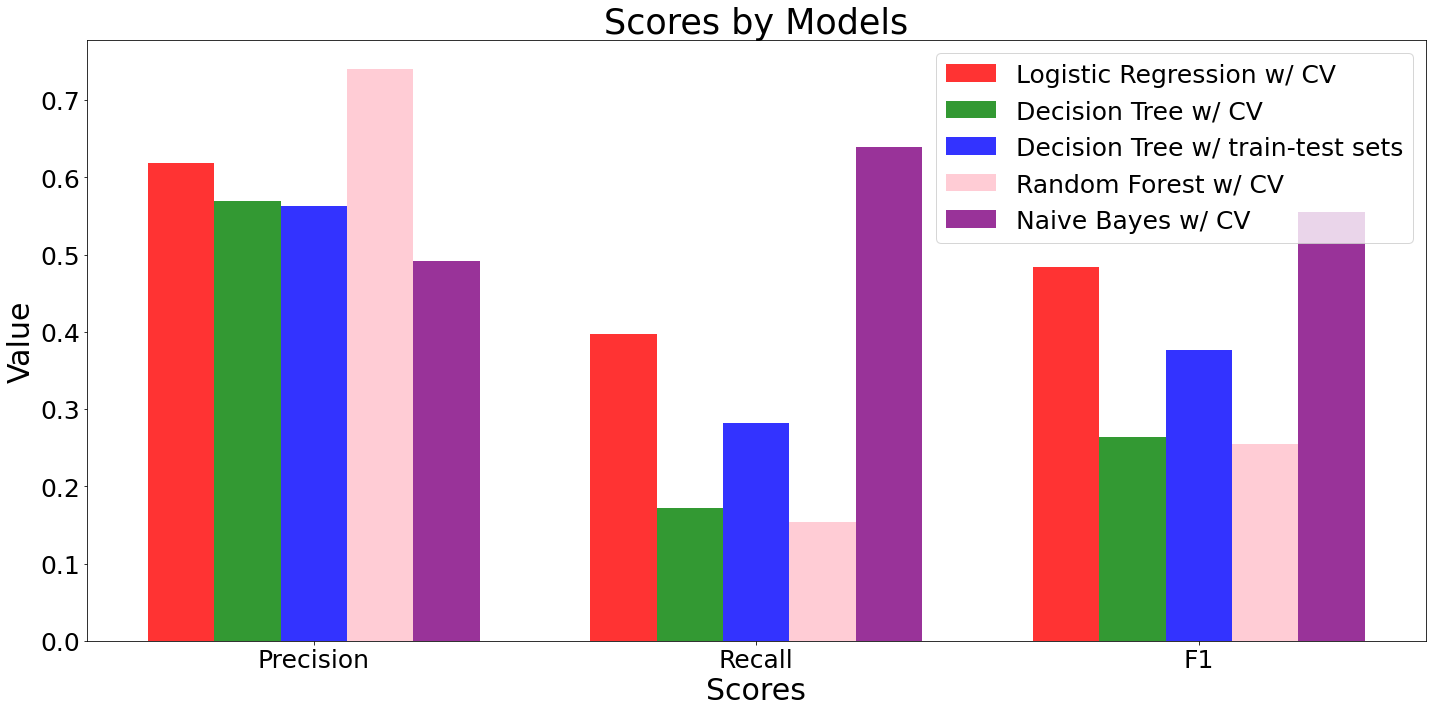

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3

# create plot
fig, ax = plt.subplots(figsize=(20,10))
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

logreg = plt.bar(index - bar_width, lr_results, bar_width,
alpha=opacity,
color='r',
label='Logistic Regression w/ CV')

crosvaldt = plt.bar(index, dt_cv_results, bar_width,
alpha=opacity,
color='g',
label='Decision Tree w/ CV')

traintestdt = plt.bar(index + bar_width, dt_tt_results, bar_width,
alpha=opacity,
color='b',
label='Decision Tree w/ train-test sets')

randomfor = plt.bar(index + bar_width*2, rf_results, bar_width,
alpha=opacity,
color='pink',
label='Random Forest w/ CV')

naivebay = plt.bar(index + bar_width*3, nb_results, bar_width,
alpha=opacity,
color='purple',
label='Naive Bayes w/ CV')

plt.xlabel('Scores', fontsize=30)
plt.ylabel('Value', fontsize=30)
plt.title('Scores by Models', fontsize=35)
plt.xticks(index + bar_width, ('Precision', 'Recall', 'F1'), fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.tight_layout()
plt.show()

<u>Conclusion</u>

In conclusion, **our most precise mode is the Random Forest with cross-validation**. However, the model is precise at the cost of recall -- it implies that the model has a low level of false positive but a **high level of false negative**. However, we are looking at whether a campaign on kickstarter is successful or not. i.e. having some amount of false positives is **less important than reducing our amount of false negative (i.e. we want to increase our Recall**.

As such, the F1 measure is important in this situation. As such, our **Naive Bayes with cross-validation** model has a **high recall** compared to other models, which is reflected in the model having the highest F1 score.

<hr>

## Annex.1. Running a Deep Learning Model with BigDL

<span style="color:red">/!\ Does not run on Google Cloud as the support for Python 2.7 is discontinued.</span>

In [89]:
!python --version

Python 3.8.5


## Annex.2. Running a Deep Learning Model with Elephas

<span style="color:red">/!\ Does not run on Google Cloud as the available tensorflow versions are below the required 2.2 one.</span>

### Annex.2.1.  Transforming the dataset & declaring model hyper-parameters

We will be reusing the first dataset we processed.

### Annex.2.2. Creating a model pipeline using Train-Test split

#### Annex.2.2.1. Building the model

#### Annex.2.2.2. Fitting and Evaluating the model